In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../../..')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import datetime

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.evaluation import show_metrics

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.cmap'] = 'viridis'

%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

In [3]:
%%time

ROOT_DIR = '../../../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False

class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path,
    ROOT_DIR,
    split=(0.8, 0.15, 0.05),
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq

model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../../../tmp\logs\20210408-140951
Wall time: 15.6 ms


In [4]:
masks_counts = [16, 128, 256, 512, 1024, 2048, 3072, 4096, 6144, 8192, 16384, 32768]
experiments_counts = [100, 100, 100, 100, 100, 100, 50, 50, 25, 25, 15, 5]

In [5]:
masks_to_experiments = {}
for a, b in zip(masks_counts, experiments_counts):
    masks_to_experiments[a] = b

In [6]:
import matplotlib.pyplot as plt

In [7]:
from os import listdir
from os.path import isfile, join

fPath = os.path.join(ROOT_DIR, "risei-stability/v2")

files = [f for f in listdir(fPath) if isfile(join(fPath, f))]

In [8]:
files

['1617280079_m16.npy',
 '1617283634_m128.npy',
 '1617288810_m256.npy',
 '1617299107_m512.npy',
 '1617466451_m1024.npy',
 '1617807173_m16.npy',
 '1617807419_m16.npy',
 '1617808162_m16.npy',
 '1617866908_m2048.npy']

In [9]:
import re
import pandas as pd

data = {
    "masks_count": [],
    "experiments_count": [],
    "std_heatmaps": [],
    "std_mean": [],
    "std_25p": [],
    "std_50p": [],
    "std_75p": [],
    "std_min": [],
    "std_max": [],
}

p_data = {
   "masks_count": [],
   "std_voxel": [],
   "metric": [],
}

new_data = {
    "masks_count": [],
    "experiments_count": [],
    "std_voxel": [],
}

for file in files:
    match = re.match("\d+_m(\d+).npy", file)
    if not match:
        print(f'could not parse {file}')
        continue
    
    masks_count = int(match[1])
    experiments_count = masks_to_experiments[masks_count]
    std_heatmaps = np.load(os.path.join(fPath, file))
    data["masks_count"].append(masks_count)
    data["experiments_count"].append(experiments_count)
    data["std_heatmaps"].append(std_heatmaps)
    data["std_mean"].append(np.mean(std_heatmaps))
    data["std_25p"].append(np.percentile(std_heatmaps, 25))
    data["std_50p"].append(np.median(std_heatmaps))
    data["std_75p"].append(np.percentile(std_heatmaps, 75))
    data["std_min"].append(np.min(std_heatmaps))
    data["std_max"].append(np.max(std_heatmaps))
    
    for metric in ["std_mean", "std_25p", "std_50p", "std_75p", "std_min", "std_max"]:
        p_data["masks_count"].append(masks_count)
        p_data["metric"].append(metric)
        p_data["std_voxel"].append(data[metric][-1])
    
    new_std_heatmaps = std_heatmaps.flatten()
    for std_voxel in new_std_heatmaps:
        new_data["masks_count"].append(masks_count)
        new_data["experiments_count"].append(experiments_count)
        new_data["std_voxel"].append(std_voxel)
    
df = pd.DataFrame(data=data)
new_df = pd.DataFrame(data=new_data)
p_df = pd.DataFrame(data=p_data)

In [10]:
def stats(row):
    std_heatmaps = row[1]["std_heatmaps"]
    
    print(f'Note: values in a heatmap are in the range <0, 1> (heatmap represents the heat = avg activation for each voxel)')
    print(f'masks = {row[1]["masks_count"]}, experiments = {row[1]["experiments_count"]}')
    print(f"\tmean std: {np.mean(std_heatmaps)}")
    print(f"\tmin std: {np.min(std_heatmaps)}")
    print(f"\tmax std: {np.max(std_heatmaps)}")
    print(f"\tstd std: {np.std(std_heatmaps)}")
    print(f'\n')

In [11]:
def boxplot(row):  
    ax = sns.boxplot(x=row[1]['std_heatmaps'])
    xlabel = f'Rozsah hodnôt štandradných odchýlok jednotlivých voxelov tepelných máp v {row[1]["experiments_count"]} experimentoch (počet masiek použitých na vytvorenie tepelnej mapy = {row[1]["masks_count"]})'
    ax.set_xlim([0, 0.1])
    ax.set_xlabel(xlabel)
#     ax.legend()
    plt.show()

In [12]:
batch_x, batch_y, *_ = test_seq[0]
idx = 0
image_x, image_y = batch_x[idx], batch_y[idx]

## Used image

This is not relevant, since we are comparing to the heatmaps.

No handles with labels found to put in legend.


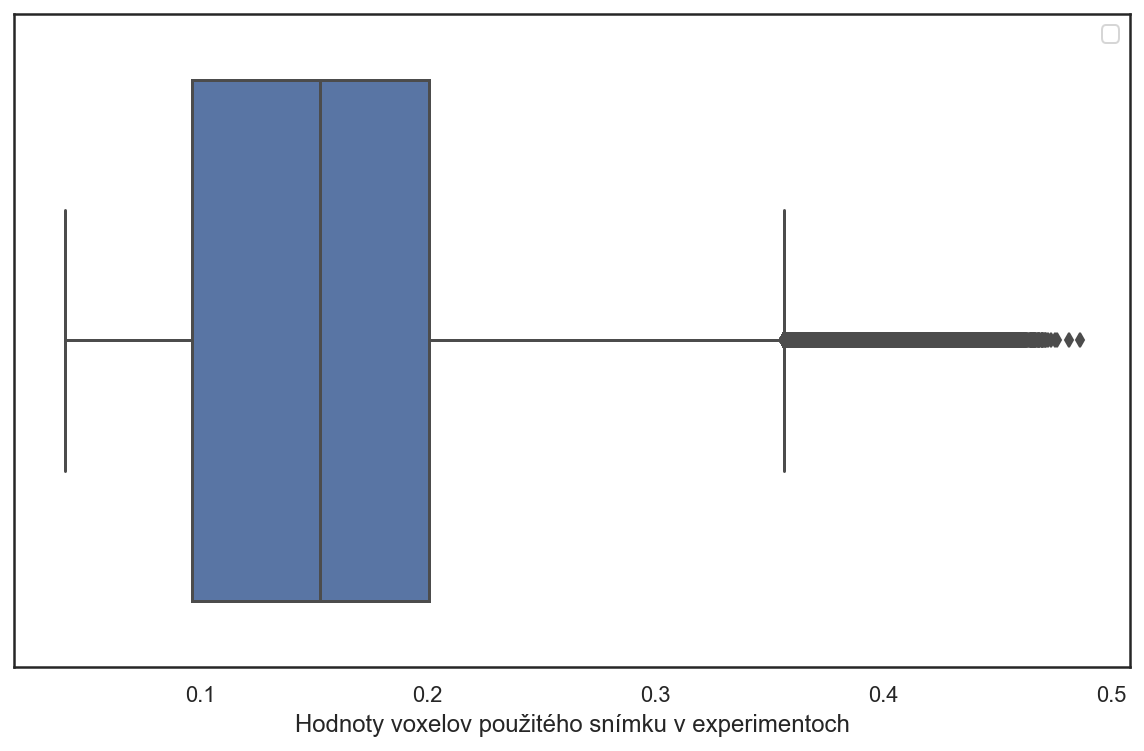

In [13]:
ax = sns.boxplot(x=image_x)
ax.set_xlabel('Hodnoty voxelov použitého snímku v experimentoch')
ax.legend()

## Experiments

In [14]:
for row in df.iterrows():
     stats(row)

Note: values in a heatmap are in the range <0, 1> (heatmap represents the heat = avg activation for each voxel)
masks = 16, experiments = 100
	mean std: 0.05955613082953926
	min std: 0.046477961912158
	max std: 0.07712610837588707
	std std: 0.003500802479298542


Note: values in a heatmap are in the range <0, 1> (heatmap represents the heat = avg activation for each voxel)
masks = 128, experiments = 100
	mean std: 0.02075109456326909
	min std: 0.01647974358325526
	max std: 0.02536017067711848
	std std: 0.0011368710589203127


Note: values in a heatmap are in the range <0, 1> (heatmap represents the heat = avg activation for each voxel)
masks = 256, experiments = 100
	mean std: 0.014828078764462703
	min std: 0.011839998788771497
	max std: 0.018364036426272524
	std std: 0.0008240467381456897


Note: values in a heatmap are in the range <0, 1> (heatmap represents the heat = avg activation for each voxel)
masks = 512, experiments = 100
	mean std: 0.010492623011419382
	min std: 0.0084497330

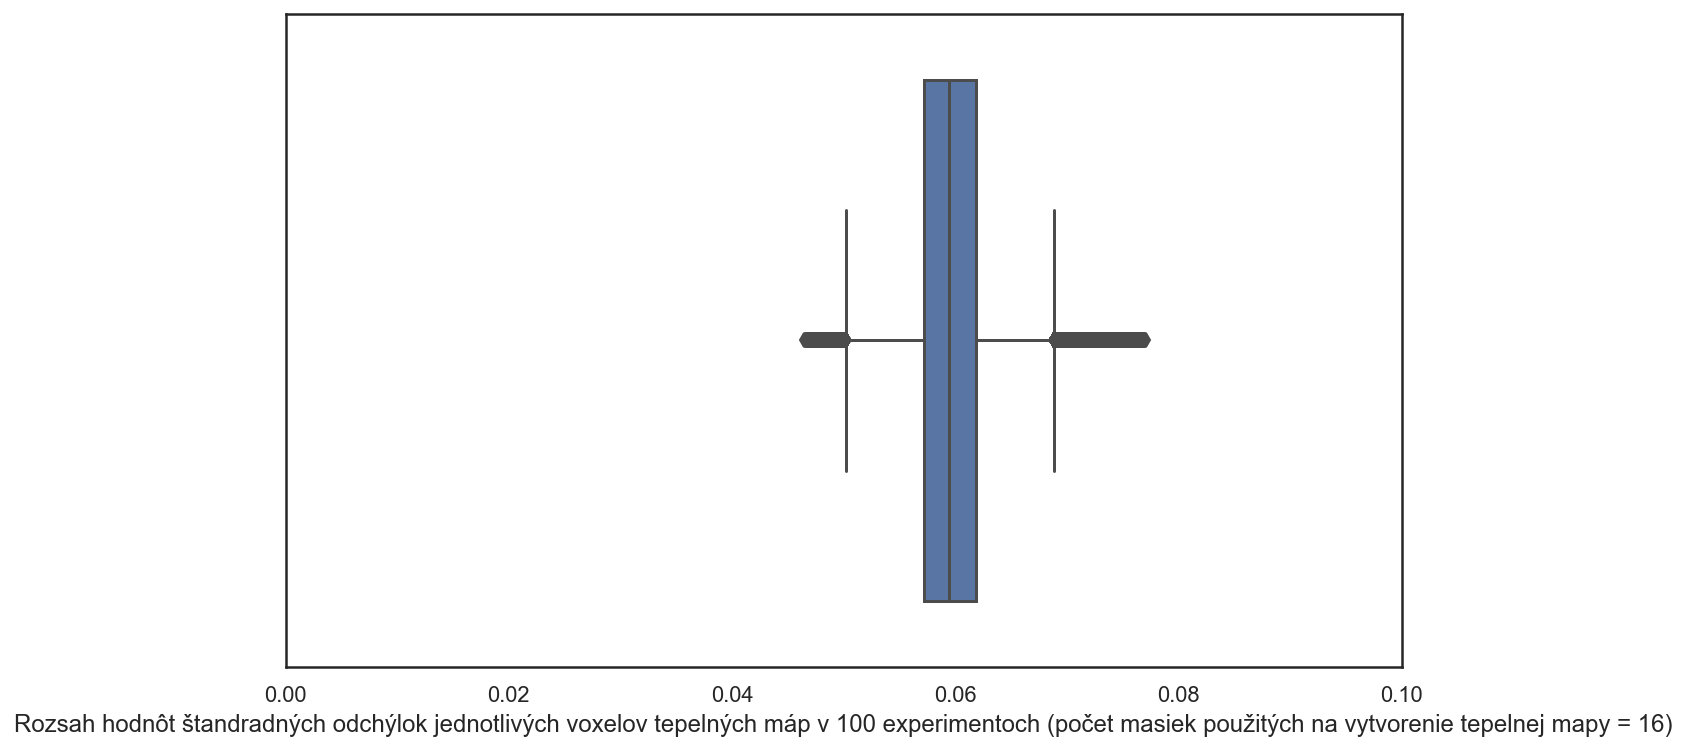

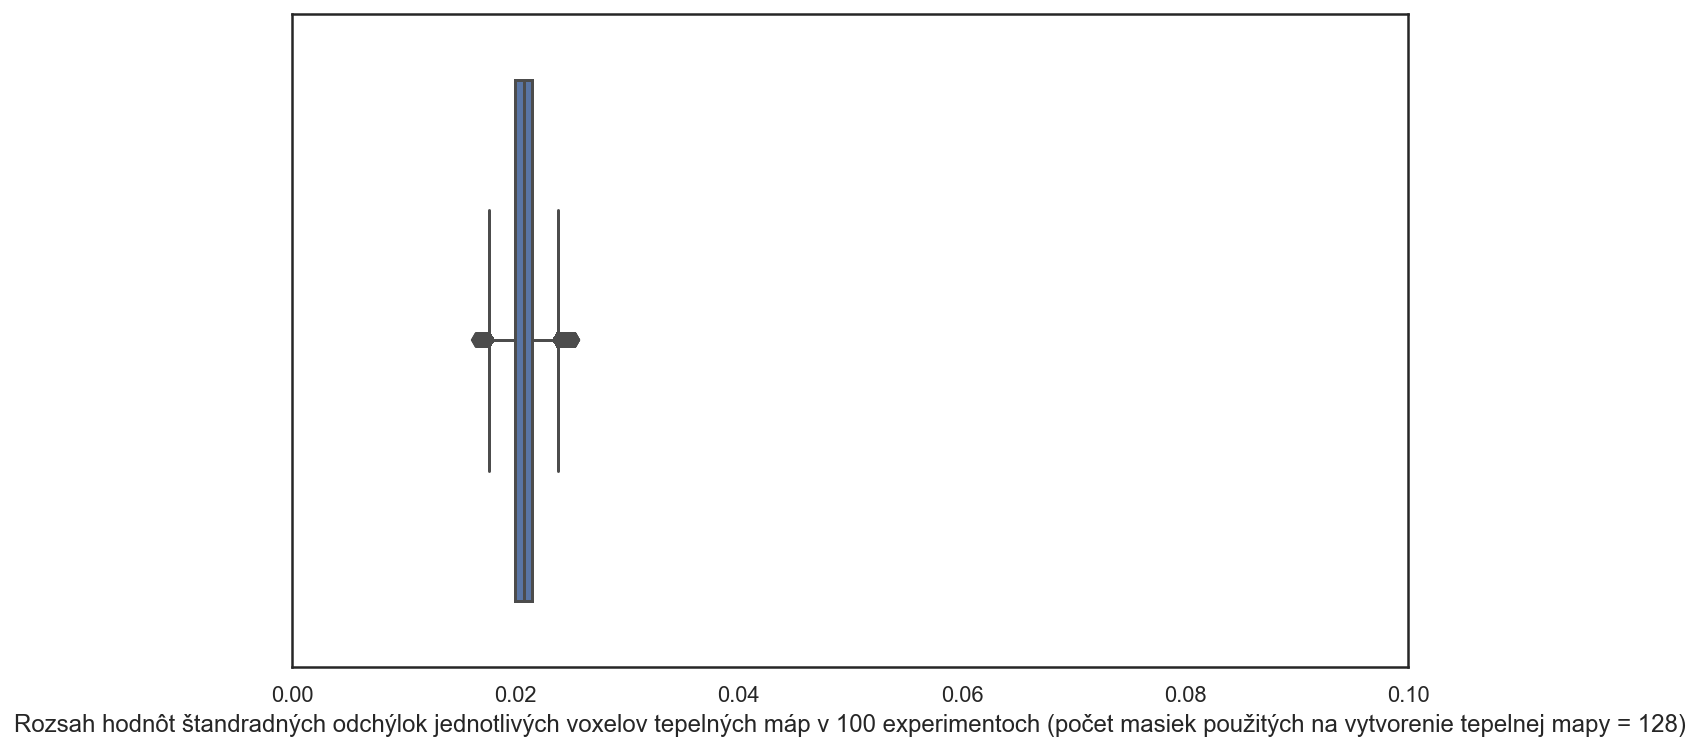

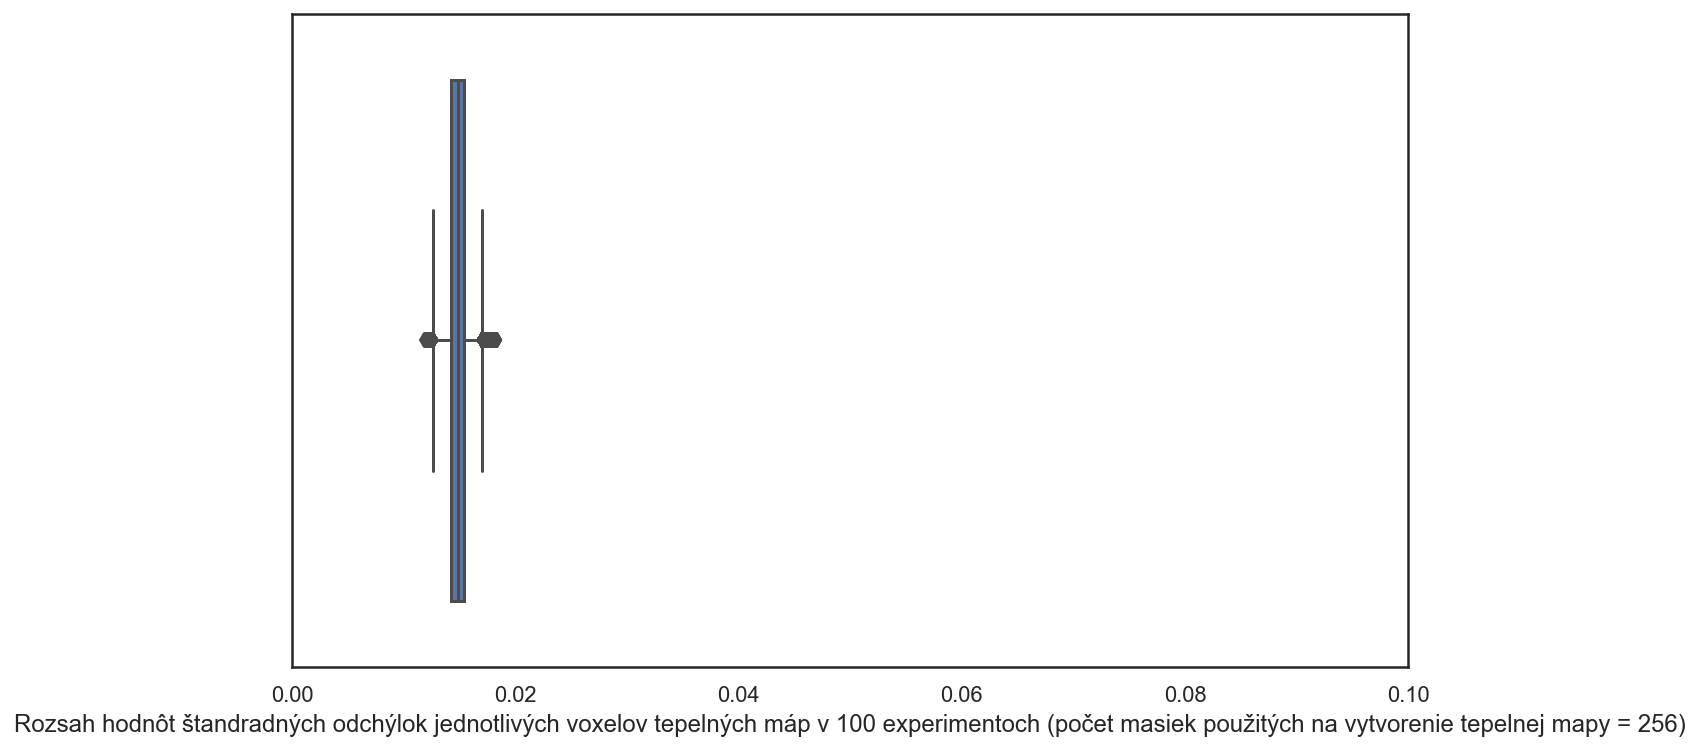

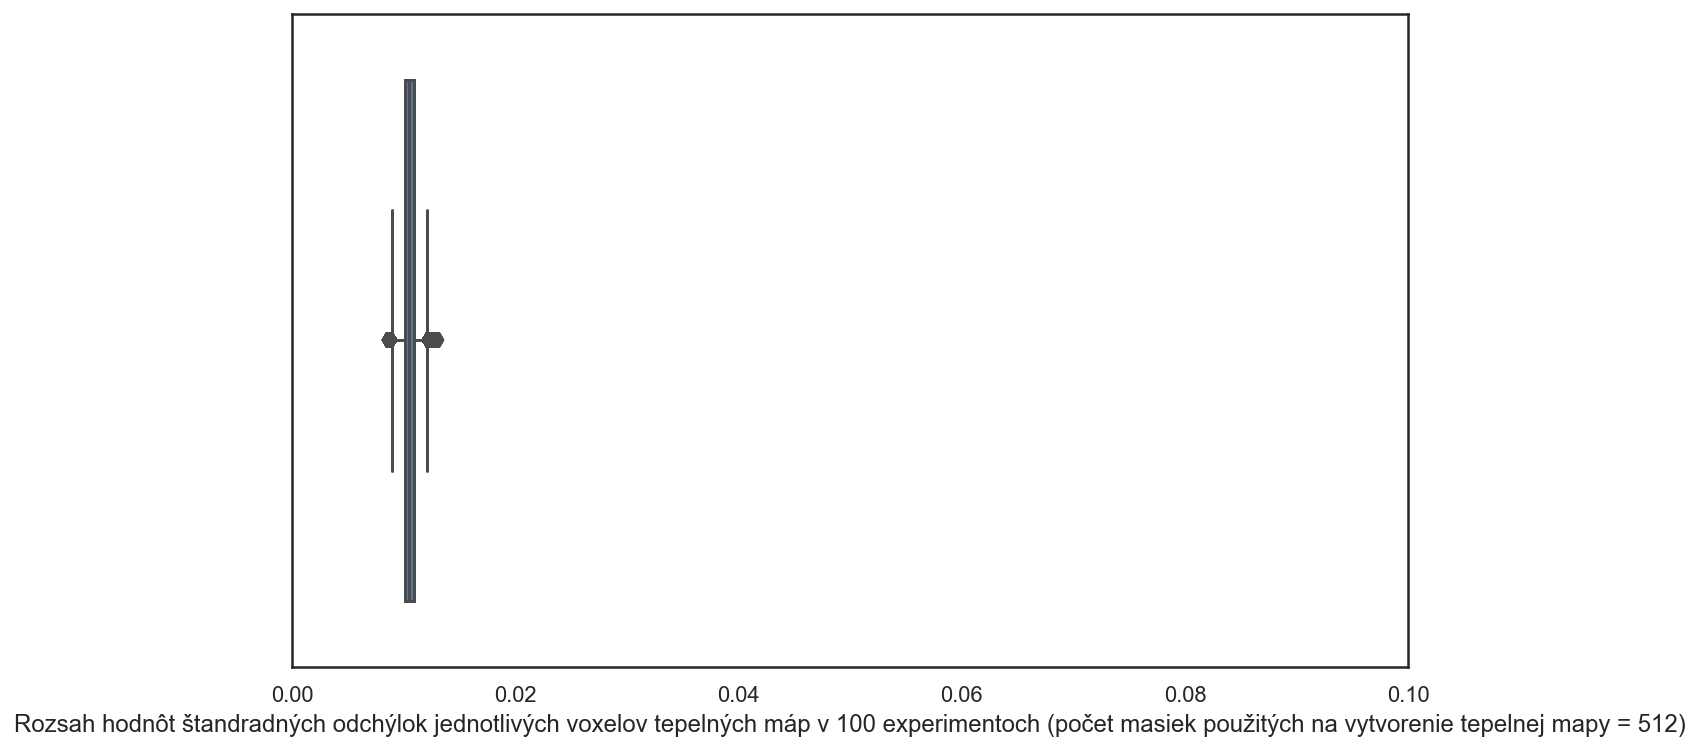

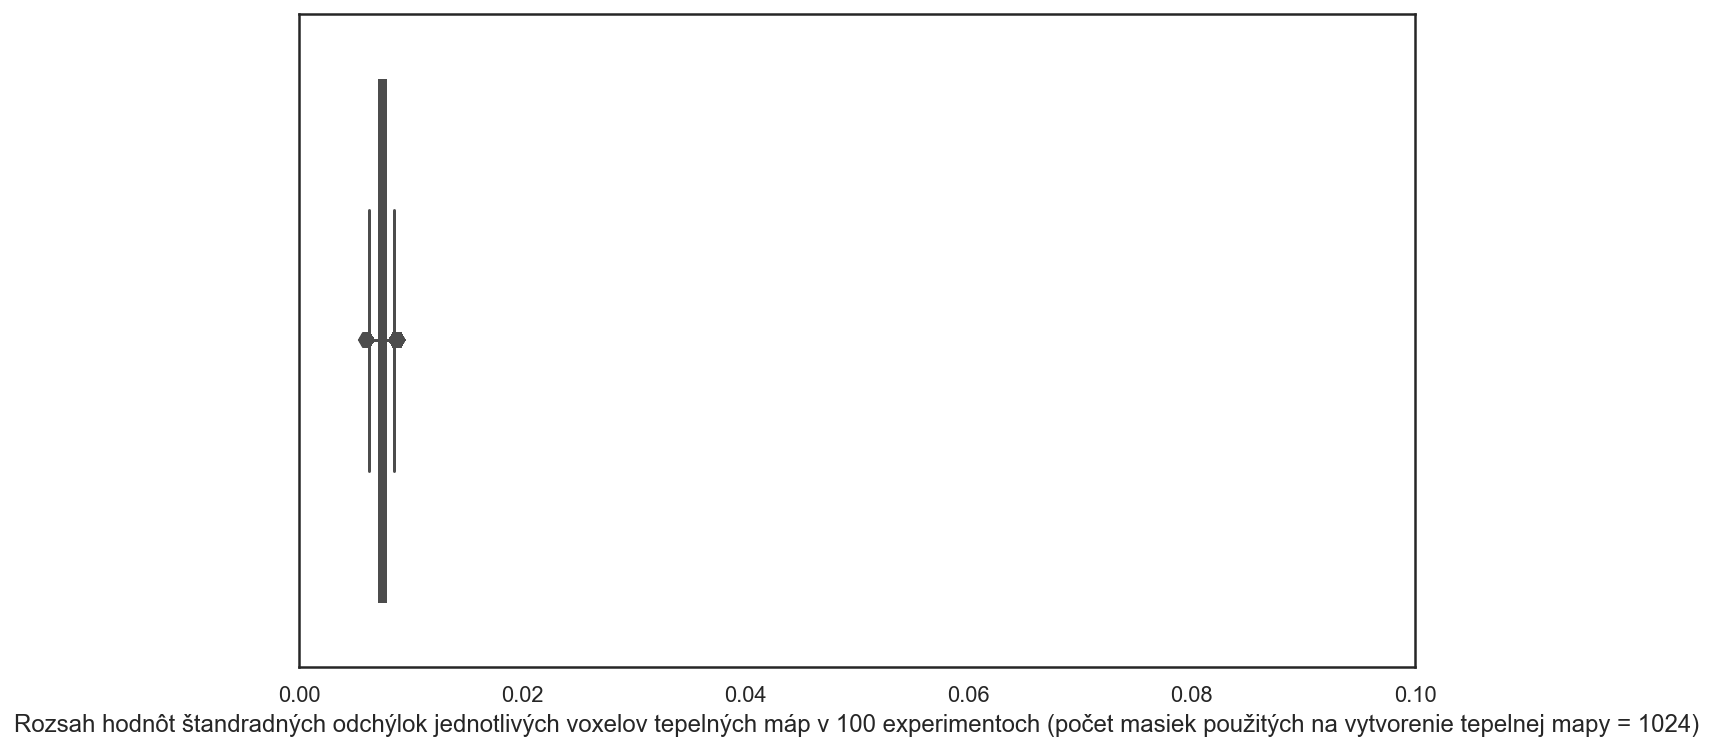

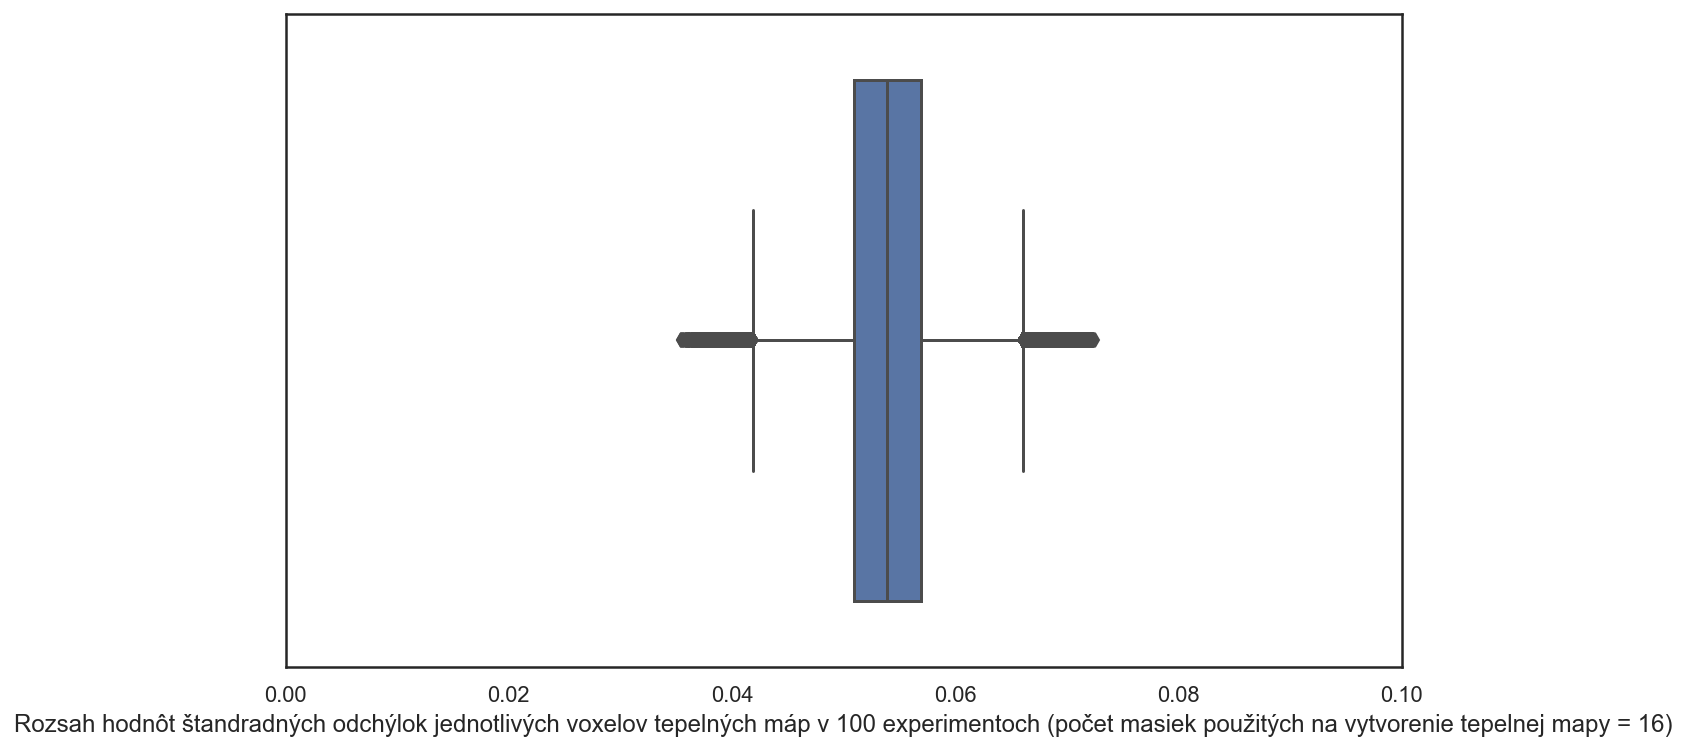

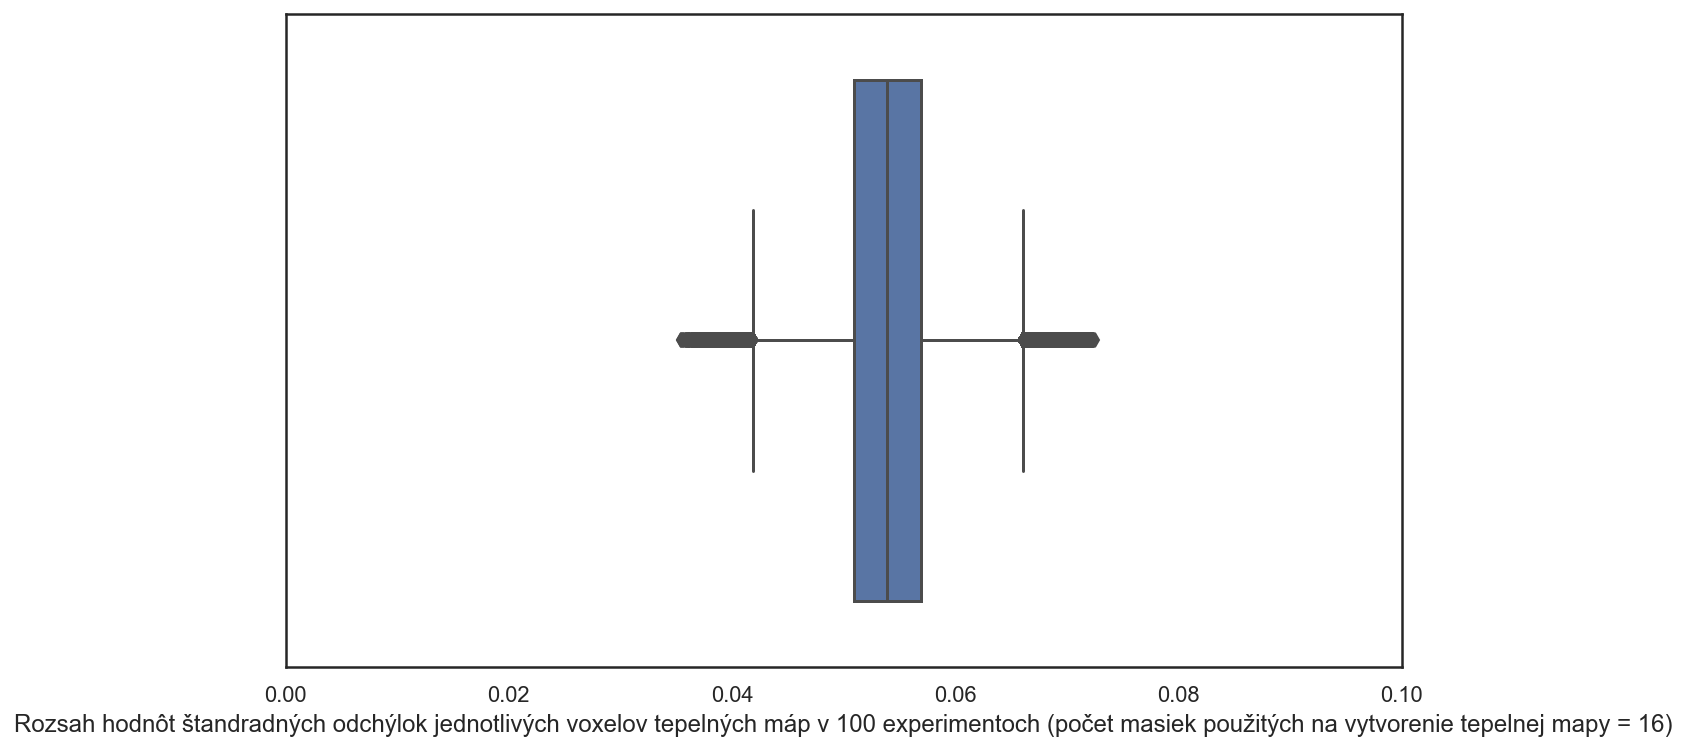

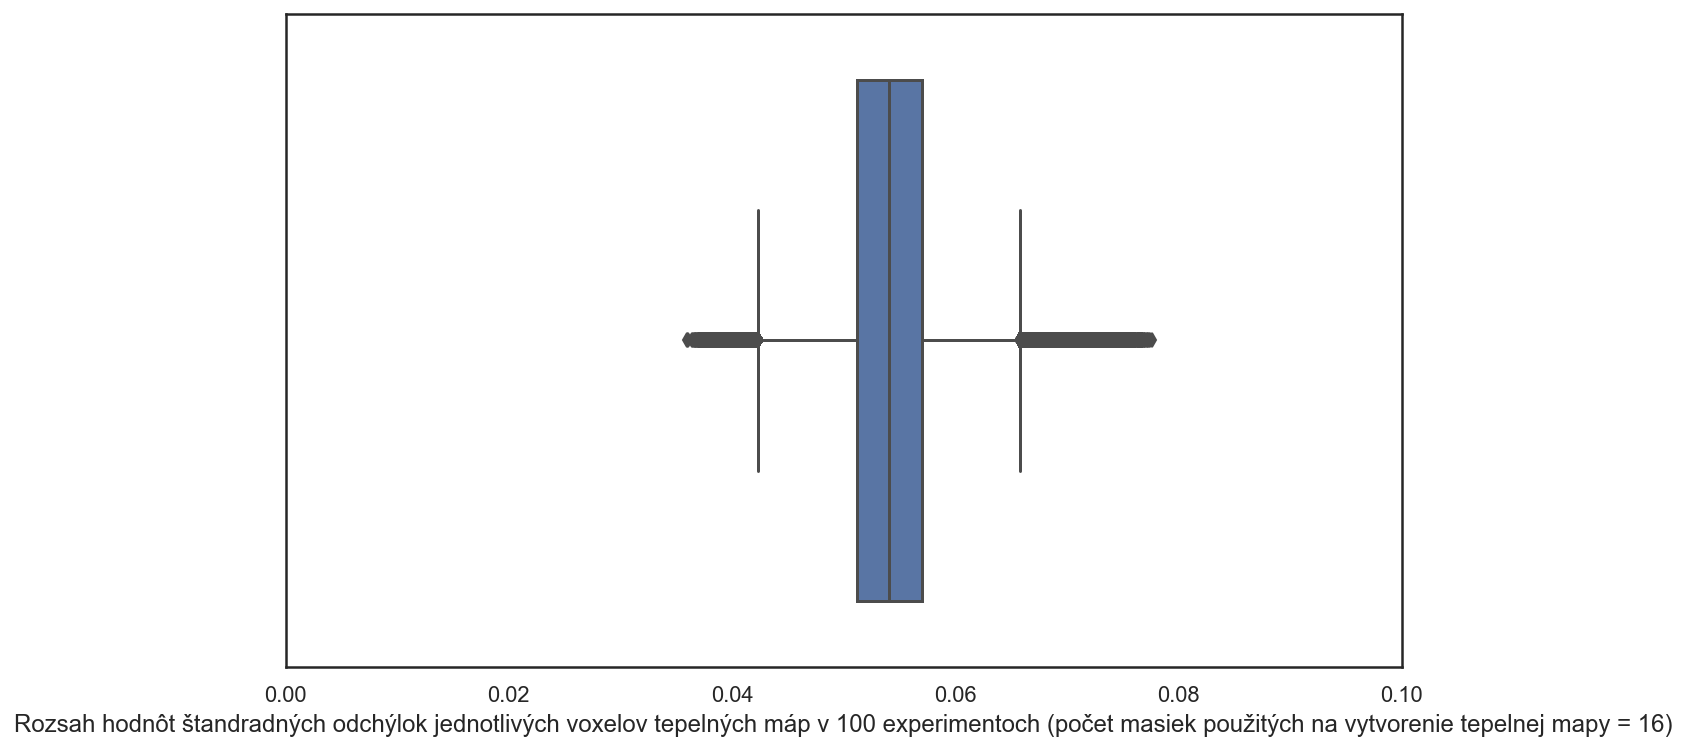

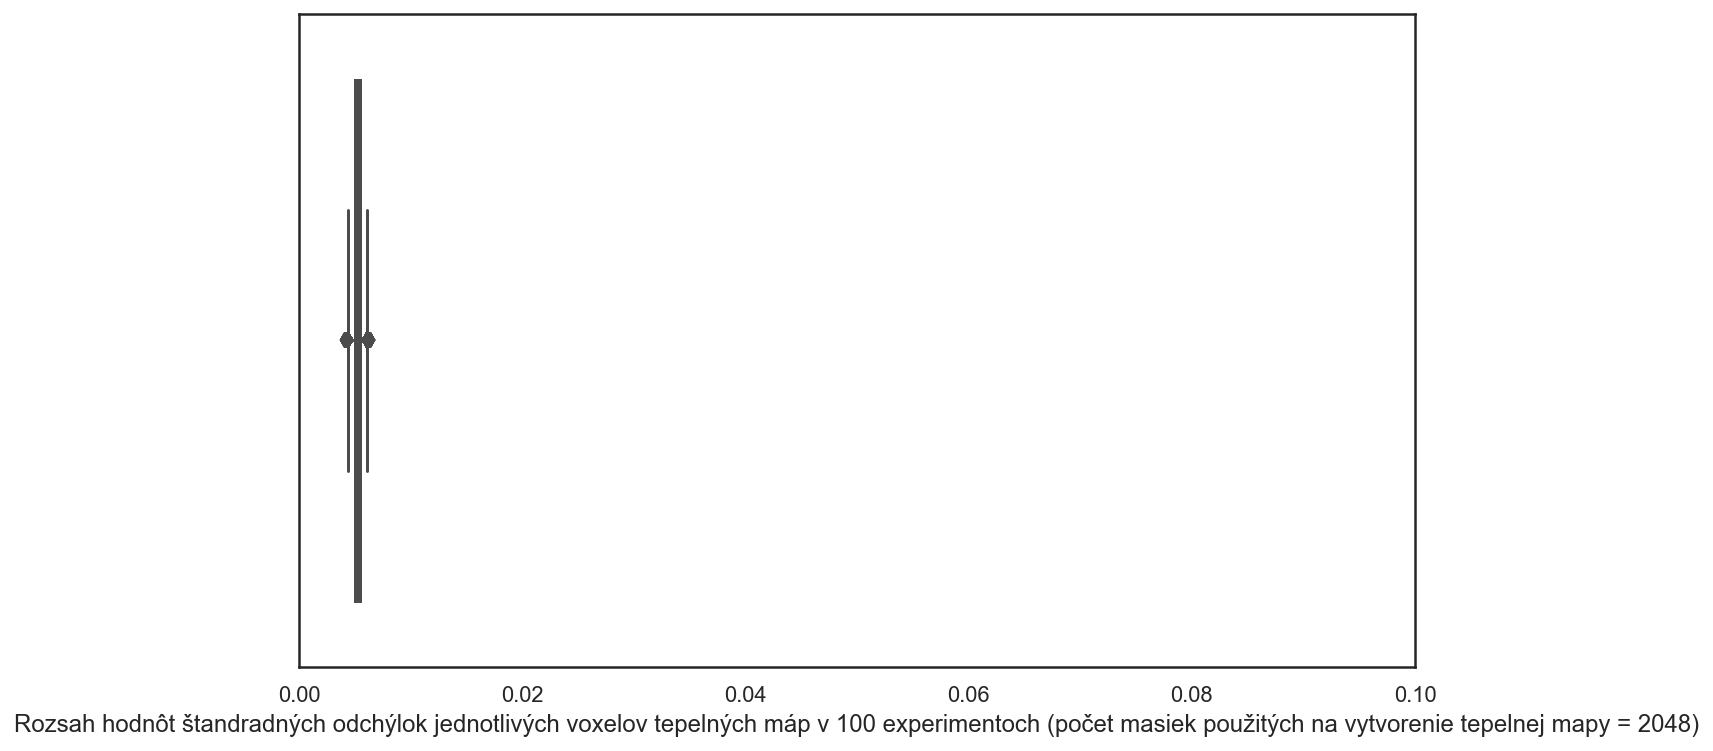

In [15]:
for row in df.iterrows():
     boxplot(row)

<AxesSubplot:xlabel='Počet vygenerovaných masiek', ylabel='Štandardná odchýlka tepla pre voxel'>

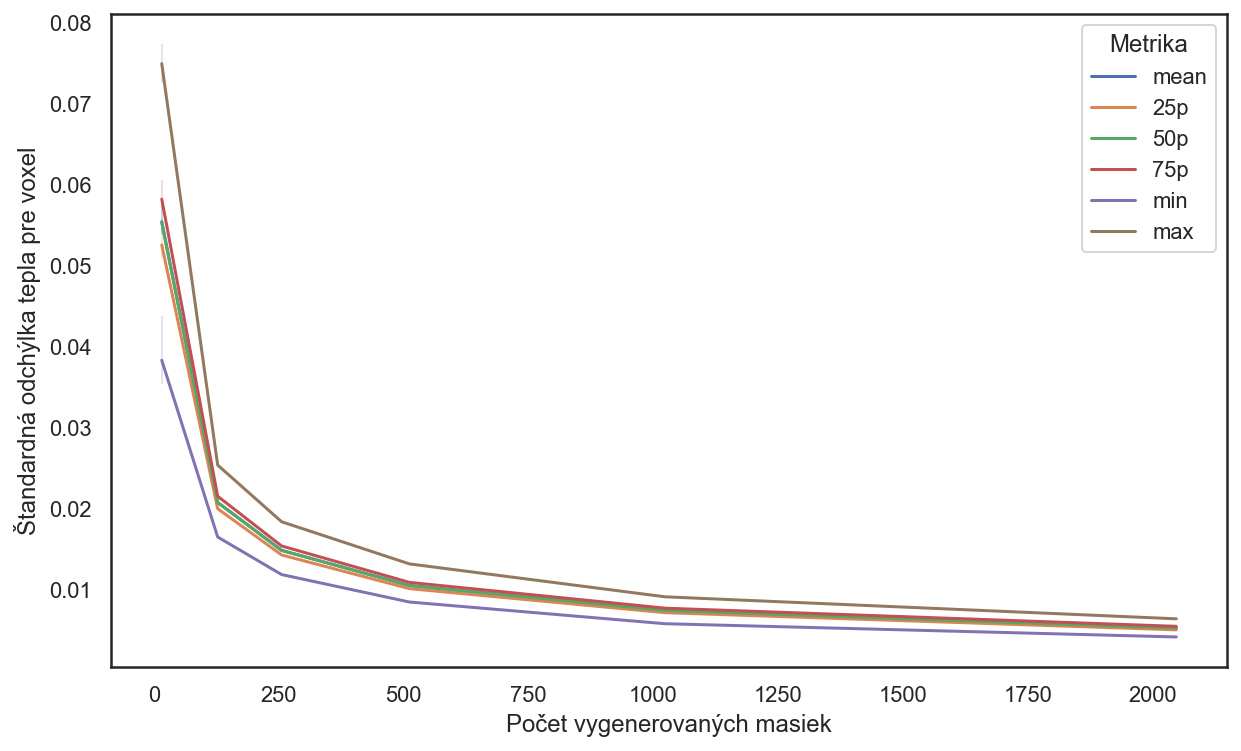

In [16]:
masks_count_name = "Počet vygenerovaných masiek"
std_voxel_name = "Štandardná odchýlka tepla pre voxel"
metric_name = "Metrika"
sk_df = p_df.rename(columns={"masks_count": masks_count_name, "std_voxel": std_voxel_name, "metric": metric_name})
sk_df[metric_name] = sk_df[metric_name].map(lambda x: x.replace('std_', ''))
sk_df = sk_df[sk_df[masks_count_name] >= 0]

sns.lineplot(data=sk_df, x=masks_count_name, y=std_voxel_name, hue=metric_name, markers=True)

<AxesSubplot:xlabel='Počet vygenerovaných masiek', ylabel='Štandardná odchýlka tepla pre voxel'>

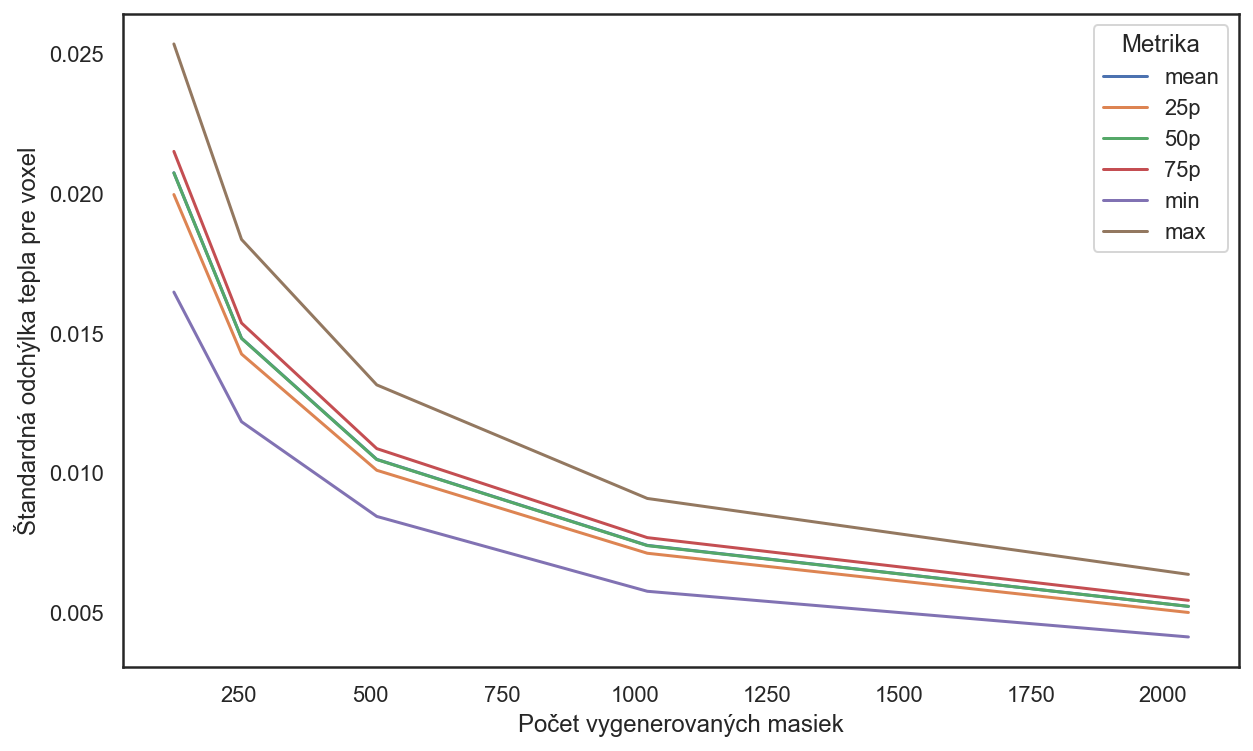

In [17]:
masks_count_name = "Počet vygenerovaných masiek"
std_voxel_name = "Štandardná odchýlka tepla pre voxel"
metric_name = "Metrika"
sk_df = p_df.rename(columns={"masks_count": masks_count_name, "std_voxel": std_voxel_name, "metric": metric_name})
sk_df[metric_name] = sk_df[metric_name].map(lambda x: x.replace('std_', ''))
sk_df = sk_df[sk_df[masks_count_name] >= 128]

sns.lineplot(data=sk_df, x=masks_count_name, y=std_voxel_name, hue=metric_name, markers=True)

<AxesSubplot:xlabel='Počet vygenerovaných masiek', ylabel='Štandardná odchýlka tepla pre voxel'>

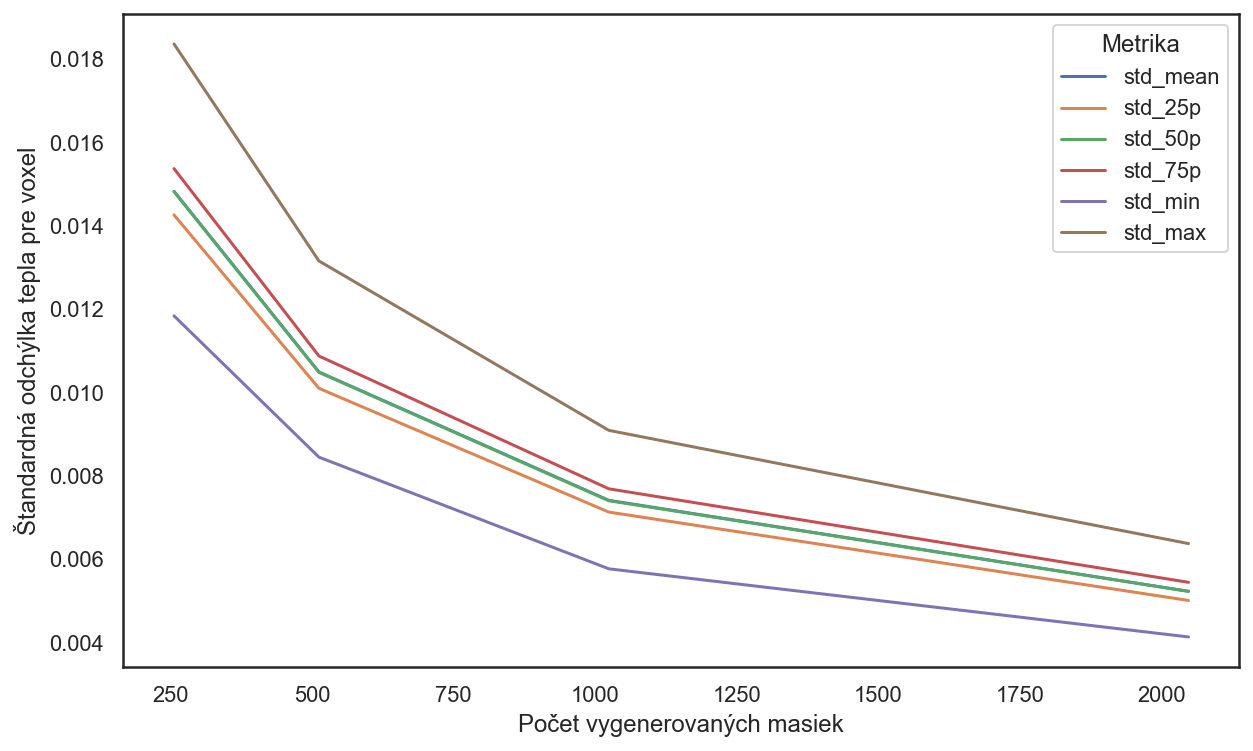

In [18]:
masks_count_name = "Počet vygenerovaných masiek"
std_voxel_name = "Štandardná odchýlka tepla pre voxel"
metric_name = "Metrika"
sk_df = p_df.rename(columns={"masks_count": masks_count_name, "std_voxel": std_voxel_name, "metric": metric_name})
sk_df = sk_df[sk_df[masks_count_name] >= 256]

sns.lineplot(data=sk_df, x=masks_count_name, y=std_voxel_name, hue=metric_name, markers=True)

<AxesSubplot:xlabel='Počet vygenerovaných masiek', ylabel='Štandardná odchýlka tepla pre voxel'>

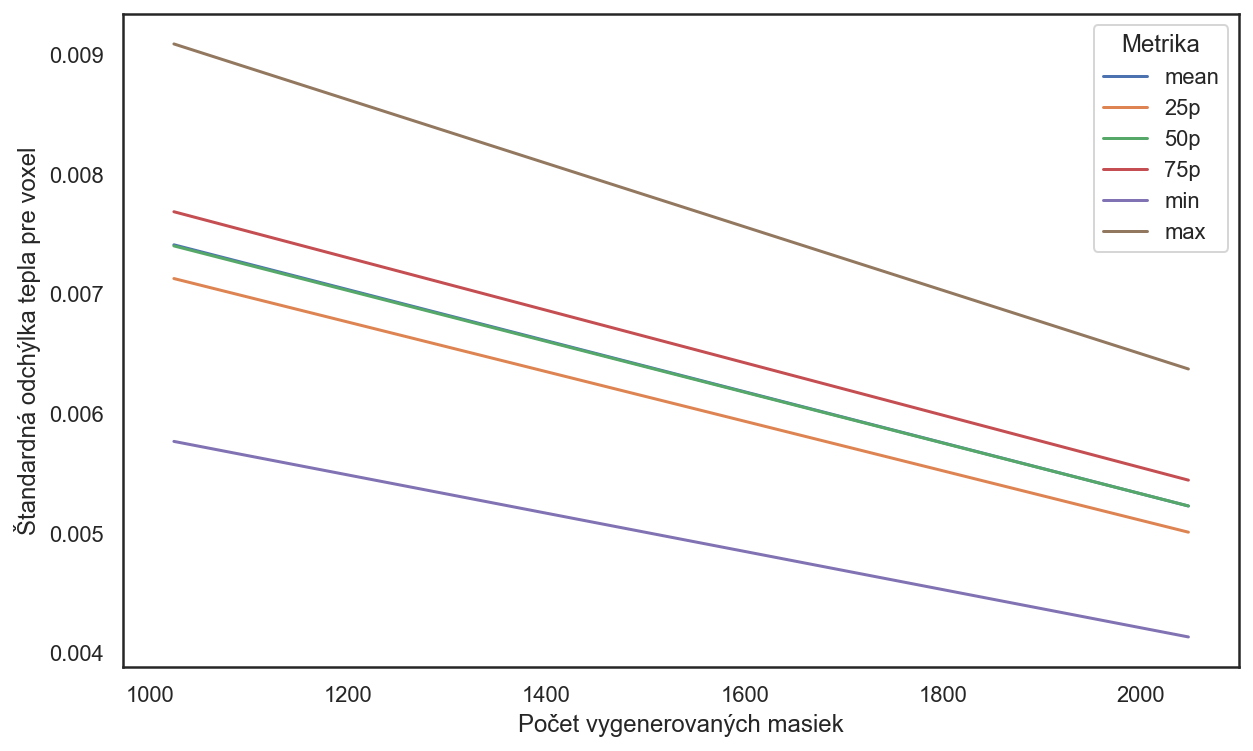

In [19]:
masks_count_name = "Počet vygenerovaných masiek"
std_voxel_name = "Štandardná odchýlka tepla pre voxel"
metric_name = "Metrika"
sk_df = p_df.rename(columns={"masks_count": masks_count_name, "std_voxel": std_voxel_name, "metric": metric_name})
sk_df[metric_name] = sk_df[metric_name].map(lambda x: x.replace('std_', ''))
sk_df = sk_df[sk_df[masks_count_name] >= 1024]

sns.lineplot(data=sk_df, x=masks_count_name, y=std_voxel_name, hue=metric_name, markers=True)

In [20]:
# plt.figure(figsize=(12, 12))
# ax = sns.boxplot(data=new_df, x='std_voxel', y='masks_count')
# ax.set_xlim([0, 0.1])
# ax.set_title('Rozsah hodnôt štandradných odchýlok jednotlivých voxelov tepelných máp')
# plt.show()